## Treemap

In order to understand the death rate and deaths in a country since statistics are available,
we will use the following two files:
```
Mortality Mx_5x5.txt
Deaths Deaths_5x5.txt
```
Take Australia's data as an example:


*death rate   Mx_5x5.txt ：*
```
Australia, Death rates (period 5x5), 	Last modified: 29 Nov 2022;  Methods Protocol: v6 (2017)

  Year          Age             Female            Male           Total
1921-1924        0             0.053821        0.068585        0.061351
1921-1924      1-4             0.005085        0.005994        0.005548
1921-1924      5-9             0.001563        0.001808        0.001687
1921-1924     10-14            0.001197        0.001510        0.001356
1921-1924     15-19            0.001853        0.002251        0.002055
1921-1924     20-24            0.002866        0.003013        0.002939
1921-1924     25-29            0.003467        0.003475        0.003471
1921-1924     30-34            0.003947        0.003962        0.003955
1921-1924     35-39            0.004852        0.005214        0.005037
1921-1924     40-44            0.005260        0.006870        0.006087
1921-1924     45-49            0.006840        0.009623        0.008275
...
```
*Deaths Deaths_5x5.txt：*
```
Australia, Deaths (period 5x5), 	Last modified: 29 Nov 2022;  Methods Protocol: v6 (2017)

  Year          Age             Female            Male           Total
1921-1924        0             13810.50        18316.55        32127.05
1921-1924      1-4              4866.97         5961.93        10828.90
1921-1924      5-9              1844.76         2193.97         4038.73
1921-1924     10-14             1312.52         1696.05         3008.57
1921-1924     15-19             1794.75         2245.92         4040.67
1921-1924     20-24             2651.09         2756.92         5408.01
1921-1924     25-29             3264.37         3108.68         6373.05
1921-1924     30-34             3614.47         3669.66         7284.13
1921-1924     35-39             3910.58         4393.89         8304.47
1921-1924     40-44             3586.49         4944.88         8531.37
... 

```

### The ideal JSON file format should be as follows:

```
{
    "Australia": {
        "1921-1924": {
            "0": {
                "Female": {
                    "rate": 0.053821,
                    "value": 13810.5  
                    },
                "Male": {
                    "rate": 0.068585,
                    "value": 18316.55   
                    },
                "Total": {
                    "rate": 0.061351,
                    "value": 32127.05
                    }
            }.....
        }.....
    }.....
}
            
```        

### data preprocessing → JSON 

In [2]:
import json

def parse_file(filename):
    data = {}
    with open(filename, 'r') as f:
        # Read the first line to get the country name
        country = f.readline().split(',')[0]

        # Skip the second line
        f.readline()

        # Read the header line
        header = f.readline().strip().split()

        # Read the rest of the file
        for line in f:
            year, age, female, male, total = line.strip().split()

            # Skip lines with invalid data
            try:
                float_female = float(female)
                float_male = float(male)
                float_total = float(total)
            except ValueError:
                continue

            if year not in data:
                data[year] = {}
            data[year][age] = {
                "Female":  float_female,
                "Male":  float_male,
                "Total": float_total
            }

    return country, data


def merge_data(mortality_data, deaths_data):
    merged_data = {}
    for year, ages in mortality_data.items():
        for age, values in ages.items():
            deaths = deaths_data[year][age]
            merged_data.setdefault(year, {}).setdefault(age, {})
            merged_data[year][age]["Female"] = {"rate": values["Female"], "value": deaths["Female"]}
            merged_data[year][age]["Male"] = {"rate": values["Male"], "value": deaths["Male"]}
            merged_data[year][age]["Total"] = {"rate": values["Total"], "value": deaths["Total"]}
    return merged_data


def main():
    mortality_file = 'Mx_5x5.txt'
    deaths_file = 'Deaths_5x5.txt'

    mortality_country, mortality_data = parse_file(mortality_file)
    deaths_country, deaths_data = parse_file(deaths_file)

    if mortality_country != deaths_country:
        raise ValueError("The countries in the files do not match.")

    merged_data = merge_data(mortality_data, deaths_data)

    json_data = {mortality_country: merged_data}

    # Save the data to a JSON file
    with open('data.json', 'w') as f:
        json.dump(json_data, f, indent=4)



if __name__ == "__main__":
    main()



{
    "Australia": {
        "1921-1924": {
            "0": {
                "Female": {
                    "rate": 0.053821,
                    "value": 13810.5
                },
                "Male": {
                    "rate": 0.068585,
                    "value": 18316.55
                },
                "Total": {
                    "rate": 0.061351,
                    "value": 32127.05
                }
            },
            "1-4": {
                "Female": {
                    "rate": 0.005085,
                    "value": 4866.97
                },
                "Male": {
                    "rate": 0.005994,
                    "value": 5961.93
                },
                "Total": {
                    "rate": 0.005548,
                    "value": 10828.9
                }
            },
            ...
        }
        ...
    }
    ...
}

### data visualization
Use plotly lib to draw the last generated file "data.json" as a Treemap

In [3]:
import json
import plotly.express as px
import plotly.io as pio

#  default browser
pio.renderers.default = "browser"


with open("data.json", "r") as f:
    data = json.load(f)

# Prepare data 
treemap_data = []
for country, years in data.items():
    for year, ages in years.items():
        for age, gender_data in ages.items():
            for gender, values in gender_data.items():
                if gender != "Total" and values["value"] > 0:
                    treemap_data.append({
                        "country": country,
                        "year": year,
                        "age": age,
                        "gender": gender,
                        "rate": values["rate"],
                        "value": values["value"]
                    })

# Ensure data is not empty
if not treemap_data:
    raise ValueError("No data points with non-zero values found.")

#treemap
fig = px.treemap(treemap_data, 
                 path=['country', 'year', 'age', 'gender'], 
                 values='value',
                 color='rate',
                 hover_data=['rate'])

fig.show()


### Change the distribution of rate and image color style

In [12]:
import json
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "browser"

with open("data.json", "r") as f:
    data = json.load(f)

treemap_data = []
for country, years in data.items():
    for year, ages in years.items():
        for age, gender_data in ages.items():
            for gender, values in gender_data.items():
                if gender != "Total" and values["value"] > 0:
                    treemap_data.append({
                        "country": country,
                        "year": year,
                        "age": age,
                        "gender": gender,
                        "rate": values["rate"],
                        "value": values["value"]
                    })

if not treemap_data:
    raise ValueError("No data points with non-zero values found.")

fig = px.treemap(treemap_data,
                 path=['country', 'year', 'age', 'gender'],
                 values='value',
                 color='rate',
                 hover_data=['rate'],
                 color_continuous_scale=px.colors.sequential.Plasma,
                 range_color=[0, 0.6]) # from 0 to 0.6 to match the color scale

fig.show()


In [10]:
import json
import plotly.express as px
import plotly.io as pio

# Set the default renderer to 'browser'
pio.renderers.default = "browser"

# Read the JSON file
with open("data.json", "r") as f:
    data = json.load(f)

# Prepare the data for the treemap
treemap_data = []
for country, years in data.items():
    for year, ages in years.items():
        for age, gender_data in ages.items():
            for gender, values in gender_data.items():
                if gender != "Total" and values["value"] > 0:
                    treemap_data.append({
                        "country": country,
                        "year": year,
                        "age": age,
                        "gender": gender,
                        "rate": values["rate"],
                        "value": values["value"]
                    })

# Ensure there is data to plot
if not treemap_data:
    raise ValueError("No data points with non-zero values found.")

# Create the treemap with a reversed custom color scale and defined range
fig = px.treemap(treemap_data,
                 path=['country', 'year', 'age', 'gender'],
                 values='value',
                 color='rate',
                 hover_data=['rate'],
                 color_continuous_scale=px.colors.sequential.Plasma_r,
                 range_color=[0, 0.8]) # from 0 to 0.8 to match the color scale

fig.show()


### Custom Colors
Make images more beautiful by customizing colors

In [11]:
import json
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "browser"

with open("data.json", "r") as f:
    data = json.load(f)

treemap_data = []
for country, years in data.items():
    for year, ages in years.items():
        for age, gender_data in ages.items():
            for gender, values in gender_data.items():
                if gender != "Total" and values["value"] > 0:
                    treemap_data.append({
                        "country": country,
                        "year": year,
                        "age": age,
                        "gender": gender,
                        "rate": values["rate"],
                        "value": values["value"]
                    })

if not treemap_data:
    raise ValueError("No data points with non-zero values found.")


# Custom color scale from light blue to dark green
custom_color_scale = ["#edf8fb", "#9ecae1","#ccece6","#6baed6", "#99d8c9","#4292c6", "#66c2a4", "#2171b5", "#41ae76", "#238b45","#08519c", "#005824","#08306b"]

fig = px.treemap(treemap_data,
                 path=['country', 'year', 'age', 'gender'],
                 values='value',
                 color='rate',
                 hover_data=['rate'],
                 color_continuous_scale=custom_color_scale,
                 range_color=[0, 0.6])

fig.show()


 ## ~~Digital Map~~
The following code is an attempt to draw an digital map with Python, but the effect is not good, so I decided to use tableau to draw the map

C:\Users\19223\AppData\Local\Temp\ipykernel_7244\3624917925.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



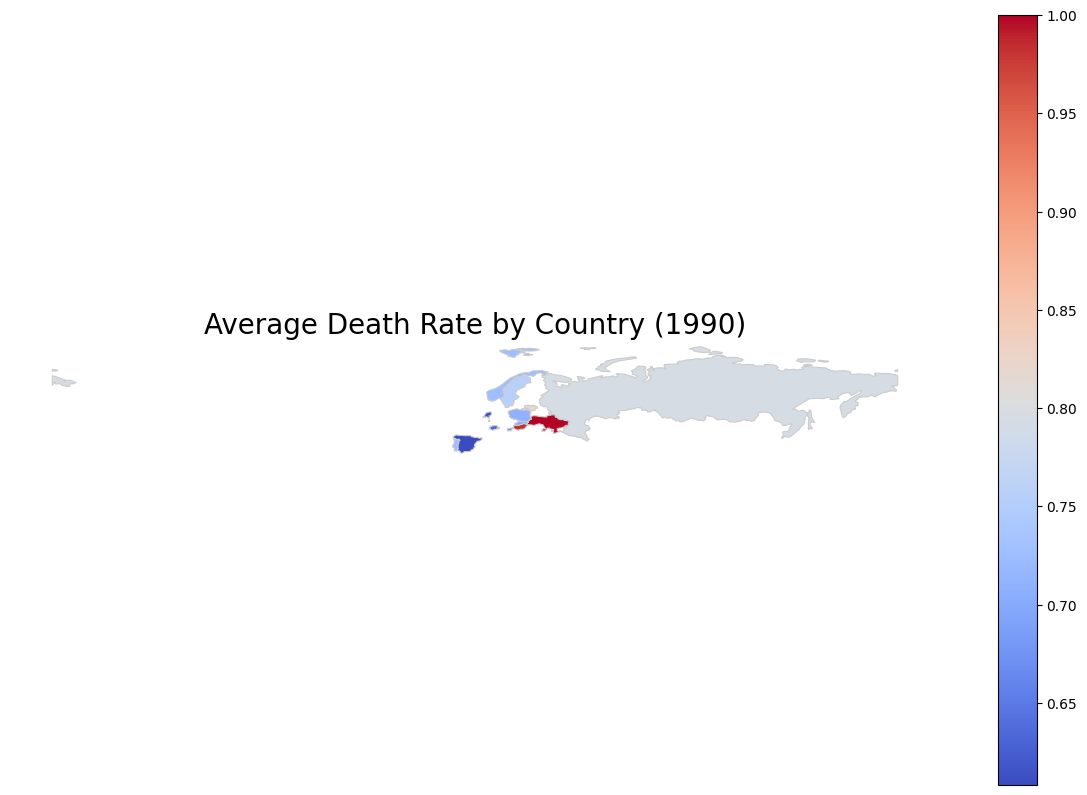

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load data from the 1990.xlsx file
data = pd.read_excel('1990.xlsx')

# Load the shapefile containing geometries of world countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the data with the shapefile
world_data = world.merge(data, left_on='name', right_on='Country Name', how='left')

# Normalize the average death rate to a 0-1 range
world_data['Average death rate_normalized'] = world_data['Average death rate'] / world_data['Average death rate'].max()

# Plot the map
fig, ax = plt.subplots(1, figsize=(15, 10))
world_data.plot(column='Average death rate_normalized', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Average Death Rate by Country (1990)', fontdict={'fontsize': 20})
ax.set_axis_off()

# Save the figure to a file
plt.savefig('world_map_death_rate.png', dpi=300)

# Show the figure
plt.show()


In [9]:
import pandas as pd
import geopandas as gpd
import plotly.express as px

# Load data from the 1990.xlsx file
data = pd.read_excel('1990.xlsx')

# Load the shapefile containing geometries of world countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the data with the shapefile
world_data = world.merge(data, left_on='name', right_on='Country Name', how='left')

# Create a choropleth map using Plotly
fig = px.choropleth(world_data, 
                    geojson=world_data.geometry.__geo_interface__, 
                    locations=world_data.index, 
                    color='Average death rate',
                    color_continuous_scale='thermal', 
                    hover_name='Country Name', 
                    hover_data=['Average death rate'],
                    projection='natural earth')

fig.update_geos(showcountries=True, countrywidth=0.2)
fig.update_layout(title='Average Death Rate by Country (1990)', margin={"r":0,"t":30,"l":0,"b":0})

# Display the figure in the browser
fig.show()



C:\Users\19223\AppData\Local\Temp\ipykernel_7244\4158346242.py:9: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

